In [29]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

PIXELS = 1024
DIMENSIONS = np.int16(math.sqrt(PIXELS))

TRAINING_FEATURES_FILE = "csvTrainImages 13440x1024.csv"
TRAINING_LABELS_FILE = "csvTrainLabel 13440x1.csv"
TESTING_FEATURES_FILE = "csvTestImages 3360x1024.csv"
TESTING_LABELS_FILE = "csvTestLabel 3360x1.csv"

def load_data(file=TRAINING_FEATURES_FILE, header=True):
    csv_path = os.path.join("dataset/", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

In [30]:
data = load_data(TRAINING_FEATURES_FILE)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from matplotlib import pyplot as plt

def imagify(arr, getimage=False, showimage=True):
    img = np.array(np.reshape(arr, (DIMENSIONS, DIMENSIONS)), dtype="uint8")
    if showimage:
        plt.imshow(img, interpolation='nearest')
        plt.gray()
        plt.show() 
        
    if getimage:
        return img

In [32]:
def showimage(img):
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.show() 

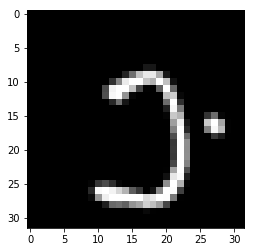

In [33]:
img = imagify(data.values[7], getimage=True)

In [34]:
th1,img1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

127.0


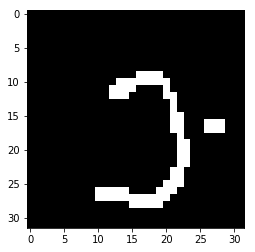

In [35]:
print(th1)
showimage(img1)

In [36]:
th2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

102.0


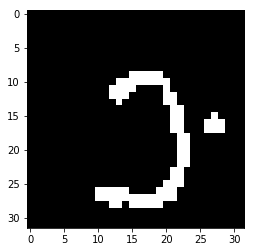

In [37]:
print(th2)
showimage(img2)

In [38]:
blur = cv2.GaussianBlur(img,(5,5),0)
th3,img3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

58.0


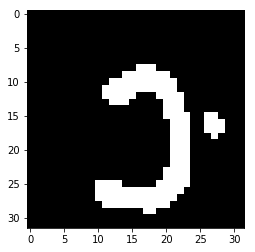

In [39]:
print(th3)
showimage(img3)

In [40]:
THRESH_BINARY = cv2.THRESH_BINARY
THRESH_BINARY_AND_THRESH_OTSU = cv2.THRESH_BINARY+cv2.THRESH_OTSU

In [41]:
def apply_thresholding(df, cap=0, thres=THRESH_BINARY_AND_THRESH_OTSU):
    if thres == None:
        return df
    
    values = df.values
    thres_values = []
    thresholding_started = False
    for value in values:
        img = imagify(value, getimage=True, showimage=False)
        th_,img = cv2.threshold(img,cap,255,thres)
        img = [img.flatten()]
        if thresholding_started:
            thres_values = np.concatenate((thres_values, img), axis=0)
        else:
            thres_values = img
            thresholding_started = True
            
    thres_df = pd.DataFrame(thres_values, columns=df.columns)
    return thres_df

In [42]:
datacopy = data.copy()
data = apply_thresholding(data, thres=THRESH_BINARY_AND_THRESH_OTSU)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.decomposition import PCA
import numpy as np

def get_dims_variances(x, min_dim, max_dim, threshold=0.1, capToThreshold=False):
    dims = []
    variances = []
    optimum_dim = min_dim
    saturation_reached = False
    for dim in range(min_dim, max_dim + 1):
        pca = PCA(n_components=dim)
        pca.fit(x)
        variance = np.array(pca.explained_variance_ratio_)
        variance = variance.min()
        if threshold < variance:
            optimum_dim = dim
        else:
            saturation_reached = True
        
        if saturation_reached and capToThreshold:
            break
        else:    
            dims.append(dim)
            variances.append(variance)
        
    return dims, variances, optimum_dim

In [44]:
#dims, variances, OPTIMUM_DIMENSION = get_dims_variances(data, 2, 100, 0.005, capToThreshold=True)
OPTIMUM_DIMENSION = 36
print(OPTIMUM_DIMENSION)
import matplotlib.pyplot as plt
#plt.plot(dims, variances)
#plt.show()

36


In [45]:
#dim_var = pd.DataFrame()
#dim_var["DIM"] = dims
#dim_var["VAR"] = variances

In [46]:
pca = PCA(n_components=OPTIMUM_DIMENSION)
training_features = pca.fit_transform(data)

In [47]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
training_features = imputer.fit_transform(training_features)

In [48]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
training_features = scalar.fit_transform(training_features)

In [49]:
data_labels = load_data(TRAINING_LABELS_FILE)
training_labels = data_labels.values.flatten()

In [50]:
test_data = load_data(TESTING_FEATURES_FILE)
test_data = apply_thresholding(test_data, thres=THRESH_BINARY_AND_THRESH_OTSU)
testing_features = pca.transform(test_data)
testing_features = imputer.transform(testing_features)
testing_features = scalar.transform(testing_features)

In [51]:
test_data_labels = load_data(TESTING_LABELS_FILE)
testing_labels = test_data_labels.values.flatten()

In [52]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

sgd_clf = SGDClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(sgd_clf), training_features, training_labels, cv=3, scoring="accuracy"))


sgd_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == sgd_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.20558036 0.18504464 0.22705961]


Accuracy on testing data set
 0.2232807383149747


In [53]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier 

knn_clf = KNeighborsClassifier()
print("Cross Val Scores on training set\n", cross_val_score(clone(knn_clf), training_features, training_labels, cv=3, scoring="accuracy"))

knn_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == knn_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.36272321 0.36116071 0.40477785]


Accuracy on testing data set
 0.515034236379875


In [54]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), training_features, training_labels, cv=3, scoring="accuracy"))

forest_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == forest_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.29955357 0.30513393 0.32395624]


Accuracy on testing data set
 0.414409050312593


In [55]:
# MLP Classifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

batch_size = 128
num_classes = 28
epochs = 30

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(OPTIMUM_DIMENSION,)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

adam = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

binarizer = LabelBinarizer()
binarizer.fit(training_labels)
training_labels = binarizer.transform(training_labels)
testing_labels = binarizer.transform(testing_labels)

history = model.fit(training_features, training_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(testing_features, testing_labels))

score = model.evaluate(testing_features, testing_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              37888     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_9 (Dense)              (None, 28)                28700     
Total params: 1,116,188
Trainable params: 1,116,188
Non-trainable params: 0
_________________________________________________________________
Train on 13439 samples, validate on 3359 samples
Epoch 1/30
13439/13439 [==============================] - 3s 221us/step - loss: 2.3070 - acc: 0.3078 - val_loss: 1.7271 - val_acc: 0.4370
Epoch 2/30
13439/13439 [==============================] - 2s 178us/step - los

In [56]:
# CNN Classifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

batch_size = 128
num_classes = 28
epochs = 30
size = np.int16(math.sqrt(OPTIMUM_DIMENSION))

model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(size, size, 1)))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

adam = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


training_features = np.reshape(training_features, (-1, size, size, 1))
testing_features = np.reshape(testing_features, (-1, size, size, 1))

binarizer = LabelBinarizer()
binarizer.fit(training_labels)
training_labels = binarizer.transform(training_labels)
testing_labels = binarizer.transform(testing_labels)

history = model.fit(training_features, training_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(testing_features, testing_labels))

score = model.evaluate(testing_features, testing_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2560      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         590080    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 28)                28700     
Total para